In [1]:
import pandas as pd
import numpy as np
import warnings
import dill

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import balanced_accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight

#avoid warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(r'/kaggle/input/guvi-cyber-security-dataset/preprocessed_df.csv')
test_df = pd.read_csv(r'/kaggle/input/guvi-cyber-security-dataset/preprocessed_test_df.csv')

In [4]:
test_df.isna().sum()

Id                       0
OrgId                    0
AlertId                  0
DetectorId               0
AlertTitle               0
IncidentGrade            0
EvidenceRole             0
DeviceId                 0
Sha256                   0
IpAddress                0
Url                      0
AccountSid               0
AccountUpn               0
AccountObjectId          0
AccountName              0
DeviceName               0
NetworkMessageId         0
ApplicationId            0
ApplicationName          0
FileName                 0
FolderPath               0
OSFamily                 0
OSVersion                0
CountryCode              0
State                    0
City                     0
month                    0
hour                     0
minute                   0
x0_CommandAndControl     0
x0_CredentialAccess      0
x0_Execution             0
x0_Exfiltration          0
x0_Impact                0
x0_InitialAccess         0
x0_Other                 0
x0_SuspiciousActivity    0
x

In [11]:
def preprocess_target_column(df: pd.DataFrame): 
        df = df.dropna(subset=['IncidentGrade'])
        df.loc[:,'IncidentGrade'] = df['IncidentGrade'].map({'BenignPositive':0,'TruePositive':1, 'FalsePositive':2})
        df.loc[:,'IncidentGrade'] = df['IncidentGrade'].astype(int)
        return df

with open('/kaggle/input/guvi-cyber-security-dataset/preprocess_pipeline.pkl','rb') as file:
     preprocessing_pipeline = dill.load(file)
     test_df = preprocess_target_column(test_df)
     test_df = preprocessing_pipeline.transform(test_df)
    

In [12]:
test_df.to_csv('/kaggle/working/preprocessed_test_df.csv',index = False)

### Model - 1

In [ ]:
# Define the parameter grid for GradientBoostingClassifier
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 5, 7]
}

# Initialize the GradientBoostingClassifier
gradient_boost = GradientBoostingClassifier()

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=gradient_boost, param_grid=param_grid, cv=3, scoring='balanced_accuracy', verbose=1)
grid_search.fit(df.drop('IncidentGrade', axis=1), df['IncidentGrade'])

# Print the best parameters and best estimator
print("Best Parameters:", grid_search.best_params_)
print("Best Estimator:", grid_search.best_estimator_)


In [ ]:
gradient_boost = GradientBoostingClassifier()
gradient_boost.fit(df.drop('IncidentGrade', axis=1), df['IncidentGrade'])

In [ ]:
with open(r'/kaggle/working/gradient_boost_weight.pkl', 'wb') as file:
    dill.dump(gradient_boost, file)

In [ ]:
# Predict on the training and test data
train_predictions = gradient_boost.predict(df.drop('IncidentGrade',axis=1))
test_predictions = gradient_boost.predict(test_df.drop('IncidentGrade',axis=1))

# Evaluate the model with balanced accuracy score
train_balanced_accuracy = balanced_accuracy_score(df['IncidentGrade'], train_predictions)
test_balanced_accuracy = balanced_accuracy_score(test_df['IncidentGrade'], test_predictions)

print("Train Balanced Accuracy:", train_balanced_accuracy)
print("Test Balanced Accuracy:", test_balanced_accuracy)

# Print classification report for detailed metrics
print("Classification Report (Test):")
print(classification_report(test_df['IncidentGrade'], test_predictions))

In [ ]:
#plotting graph predicted vs actual target
gradient_boost = pd.DataFrame()
gradient_boost['label'] = df['IncidentGrade']
gradient_boost['prediction'] = test_predictions

gradient_boost.plot()

### Model 2 - Random forest

In [ ]:
# ML Model - 1 Implementation with hyperparameter optimization techniques (i.e., GridSearch CV, RandomSearch CV, Bayesian Optimization etc.)
forest_grid = RandomForestClassifier()

forest_hyper_param = {
    'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 300, num = 10)],
    'max_depth' : [int(x) for x in np.linspace(3, 80, num = 11)],
    'min_samples_split' : [2, 3, 5],
    'min_samples_leaf' : [1, 2, 4],
    'bootstrap': [True,False]
}

forest_random_search = RandomizedSearchCV(estimator = forest_grid , param_distributions = forest_hyper_param, n_iter = 100, cv = 5, verbose=1, random_state=SEED , n_jobs = -1)

# Fit the Algorithm 
forest_random_search.fit(df.drop('IncidentGrade',axis=1), df['IncidentGrade'])

In [4]:
random_forst = forest_random_search.best_estimator_
random_forst.fit(df.drop('IncidentGrade',axis=1), df['IncidentGrade'])


RandomForestClassifier()

In [6]:
with open(r'/kaggle/working/random_forest_weights.pkl', 'wb') as file:
    dill.dump(random_forst, file)

In [7]:
# Predict on the training and test data
train_predictions = random_forst.predict(df.drop('IncidentGrade',axis=1))
test_predictions = random_forst.predict(test_df.drop('IncidentGrade',axis=1))

# Evaluate the model with balanced accuracy score
train_balanced_accuracy = balanced_accuracy_score(df['IncidentGrade'], train_predictions)
test_balanced_accuracy = balanced_accuracy_score(test_df['IncidentGrade'], test_predictions)

print("Train Balanced Accuracy:", train_balanced_accuracy)
print("Test Balanced Accuracy:", test_balanced_accuracy)

# Print classification report for detailed metrics
print("Classification Report (Test):")
print(classification_report(test_df['IncidentGrade'], test_predictions))

Train Balanced Accuracy: 0.9999496739377339
Test Balanced Accuracy: 0.7718212244751861
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.77      0.90      0.83   1752940
           1       0.87      0.74      0.80   1492354
           2       0.73      0.67      0.70    902698

    accuracy                           0.79   4147992
   macro avg       0.79      0.77      0.78   4147992
weighted avg       0.80      0.79      0.79   4147992



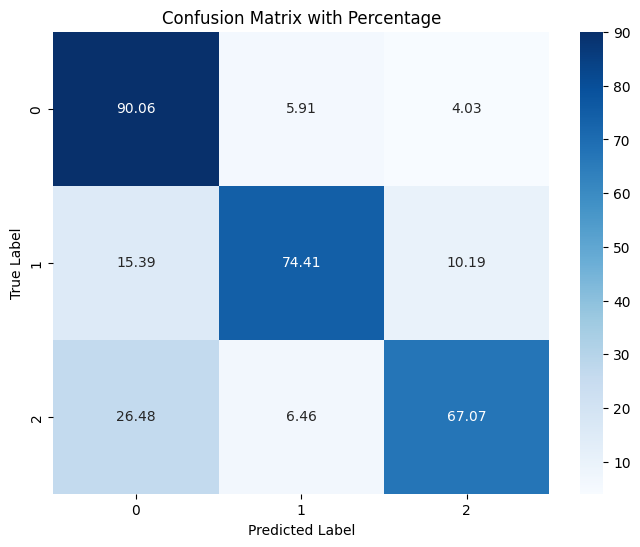

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the confusion matrix
conf_matrix = confusion_matrix(test_df['IncidentGrade'], test_predictions)

# Convert to percentage by dividing each value by the sum of its row (true class total)
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap="Blues", xticklabels=np.unique(test_df['IncidentGrade']), yticklabels=np.unique(test_df['IncidentGrade']))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix with Percentage")
plt.show()

### Model 3 - XG Boost

In [ ]:
# ML Model - 3 Implementation with hyperparameter optimization techniques (i.e., GridSearch CV, RandomSearch CV, Bayesian Optimization etc.)
xgb_grid = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)


xgb_params = {
 'max_depth': [5,8,9,12],
 'min_child_weight': [1,2,3],
 'learning_rate': [0.1,0.01,0.15],
  'n_estimators': [60,80,100,140,160]
}

xgb_grid_search = GridSearchCV(xgb_grid, xgb_params, cv=15, scoring='balanced_accuracy')

xgb_grid_search.fit(df.drop('IncidentGrade',axis =1), df['IncidentGrade'])



In [5]:
# Fit the Algorithm
xgb_grid = xgb_grid_search.best_estimator_

# Fit the best estimator to the training data
xgb_grid.fit(df.drop('IncidentGrade',axis =1), df['IncidentGrade'], sample_weight=compute_sample_weight('balanced', df['IncidentGrade']))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [14]:
with open('/kaggle/input/guvi-cyber-security-dataset/pickle_files/xgb_weights.pkl', 'rb') as file:
    xgb_grid = dill.load(file)

In [15]:
# Predict on the training and test data
train_predictions = xgb_grid.predict(df.drop('IncidentGrade',axis=1))
test_predictions = xgb_grid.predict(test_df.drop('IncidentGrade',axis=1))

# Evaluate the model with balanced accuracy score
train_balanced_accuracy = balanced_accuracy_score(df['IncidentGrade'], train_predictions)
test_balanced_accuracy = balanced_accuracy_score(test_df['IncidentGrade'], test_predictions)

print("Train Balanced Accuracy:", train_balanced_accuracy)
print("Test Balanced Accuracy:", test_balanced_accuracy)

# Print classification report for detailed metrics
print("Classification Report (Test):")
print(classification_report(test_df['IncidentGrade'], test_predictions))

Train Balanced Accuracy: 0.9996976584253856
Test Balanced Accuracy: 0.784891337461663
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.83      0.82      0.82   1752940
           1       0.86      0.77      0.81   1492354
           2       0.65      0.77      0.70    902698

    accuracy                           0.79   4147992
   macro avg       0.78      0.78      0.78   4147992
weighted avg       0.80      0.79      0.79   4147992



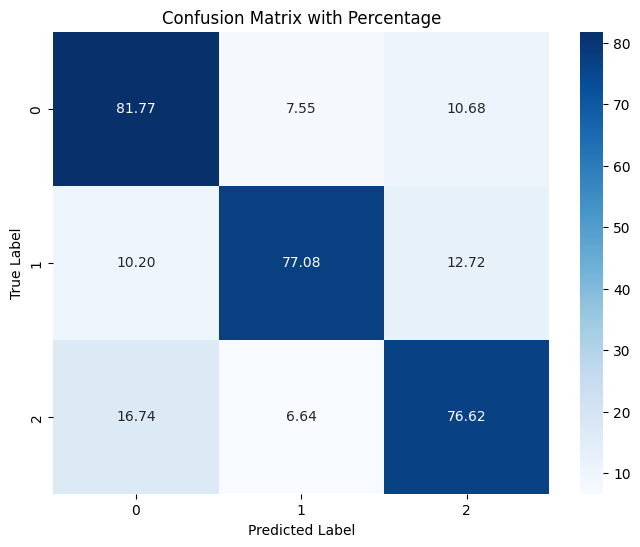

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the confusion matrix
conf_matrix = confusion_matrix(test_df['IncidentGrade'], test_predictions)

# Convert to percentage by dividing each value by the sum of its row (true class total)
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap="Blues", xticklabels=np.unique(test_df['IncidentGrade']), yticklabels=np.unique(test_df['IncidentGrade']))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix with Percentage")
plt.show()